In [1]:
# conda env deepvelo
from pathlib import Path

import numpy as np
import scvelo as scv
import torch
import scanpy as sc
import deepvelo as dv

from deepvelo.utils import (
    velocity,
    velocity_confidence,
    latent_time,
    update_dict,
    save_model_and_config,
    cross_boundary_correctness,
)
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

Using backend: pytorch
/home/jaehyunchoi/.conda/envs/deepvelo/lib/python3.8/site-packages/deepvelo/utils/plot.py:5: DeprecationWarning: deepvelo.utils.plot is deprecated. Please use deepvelo.plot.plot instead.
  warnings.warn(


In [2]:
import dgl
print(dgl.__version__)

0.6.1


In [3]:
adata=scv.read("/home/jaehyunchoi/bystander_collaboration/Figure_script_IPF/Data/Byst_cellannot.h5ad")
adata

AnnData object with n_obs × n_vars = 24129 × 32285
    obs: 'n_counts', 'n_genes', 'mt_counts', 'mt_frac', 'batch', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'celltype_detail', 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'celltype_colors', 'celltype_detail_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
# deepvelo 전처리 
# preprocess the data
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

Filtered out 22455 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 7943 highly variable genes.
computing neighbors
    finished (0:00:26) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:14) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
# run DeepVelo using the default configs
trainer = dv.train(adata, dv.Constants.default_configs)
# this will train the model and predict the velocity vectore. The result is stored in adata.layers['velocity']. You can use trainer.model to access the model.

Config Warning: Set to use GPU, but GPU version of DGL is not installed. Reset to use CPU instead.
building graph


INFO:train:Beginning training of DeepVelo_Base ...


velo data shape: torch.Size([24129, 7943])


INFO:trainer:    epoch          : 1
INFO:trainer:    time:          : 8.967053413391113
INFO:trainer:    loss           : 160565.6875
INFO:trainer:    mse            : 0.06760303676128387
INFO:trainer:    epoch          : 2
INFO:trainer:    time:          : 8.7500159740448
INFO:trainer:    loss           : 10910.3369140625
INFO:trainer:    mse            : 0.19404295086860657
INFO:trainer:    epoch          : 3
INFO:trainer:    time:          : 8.895253896713257
INFO:trainer:    loss           : 5441.79052734375
INFO:trainer:    mse            : 0.3486064374446869
INFO:trainer:    epoch          : 4
INFO:trainer:    time:          : 8.826264381408691
INFO:trainer:    loss           : 3776.195556640625
INFO:trainer:    mse            : 0.4776800870895386
INFO:trainer:    epoch          : 5
INFO:trainer:    time:          : 8.874710083007812
INFO:trainer:    loss           : 3044.89599609375
INFO:trainer:    mse            : 0.54315185546875
INFO:trainer:    epoch          : 6
INFO:train

confidence mse shape: (24129, 7943)
confidence mse stats: max 2648.597900390625, min 0.0, mean 0.21940872073173523, std 1.8028686046600342
confidence corr shape: (7943,)
confidence corr stats: max 0.9879816770553589, min -0.02612525224685669, mean 0.7538455128669739, std 0.14167487621307373
velo_mat shape: (24129, 7943)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [6]:
model = trainer.model

# 모델 구조 출력
print(model)

VeloGCN(
  (layers): ModuleList(
    (0): GraphConv(in=15886, out=64, normalization=both, activation=<function relu at 0x14bb40c19f70>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x14bb40c19f70>)
    (2): GraphConv(in=64, out=15886, normalization=both, activation=None)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)
Trainable parameters: 2053518


In [7]:
adata.write("/home/jaehyunchoi/bystander_collaboration/Figure_script_IPF/Data/Byst_deepvelo.h5ad")

In [1]:
# conda env scvelo_backup
import scvelo as scv
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

In [2]:
adata=scv.read("/home/jaehyunchoi/bystander_collaboration/Figure_script_IPF/Data/Byst_deepvelo.h5ad")

In [3]:
scv.tl.velocity_graph(adata, n_jobs = 12)

computing velocity graph (using 12/32 cores)


  0%|          | 0/24129 [00:00<?, ?cells/s]

    finished (0:04:38) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:07) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


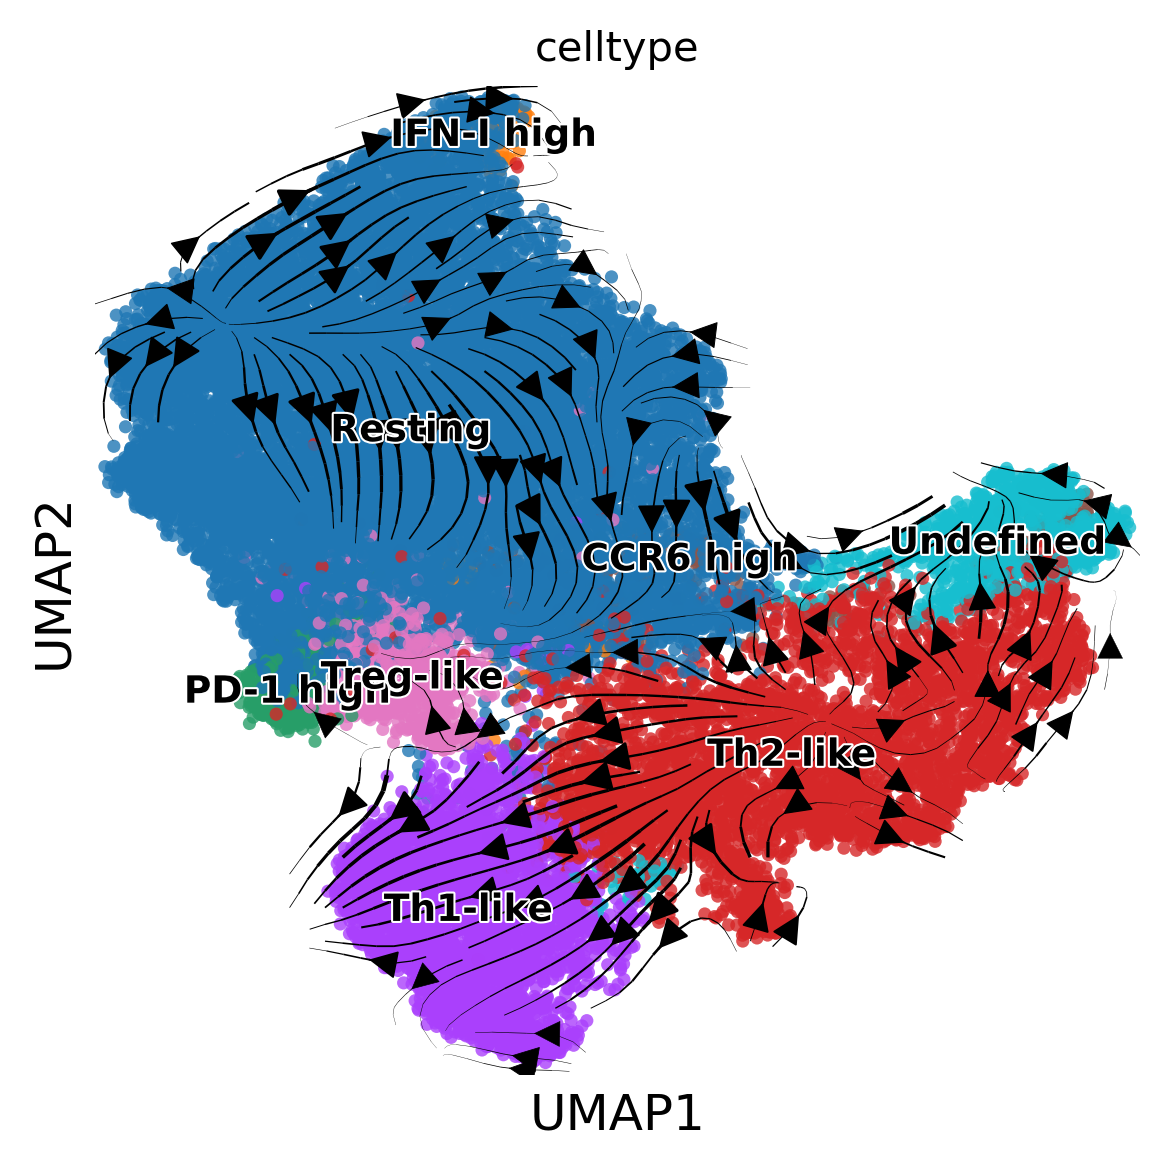

In [4]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300) 
scv.pl.velocity_embedding_stream(
    adata,
    basis='umap',
    color="celltype",
    ax=ax,
    legend_fontsize=9,
    linewidth=0.7,        # 선 두께
    alpha=0.8,            # 선 투명도
    arrow_size=1.5,       # 화살표 크기
    dpi=300,              # 해상도
    show=False           # 마지막에 plt.show()로 통합
)

# 3. Axes 조정 (깔끔한 스타일)
ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# 4. 최종 출력
plt.tight_layout()
plt.show()

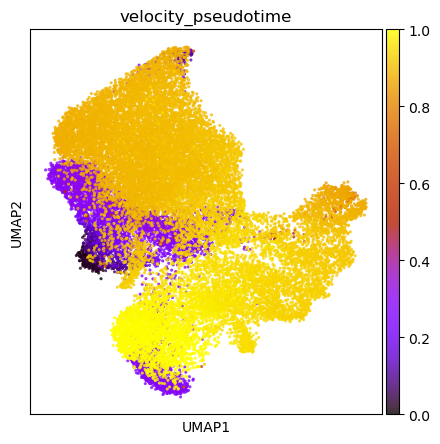

In [13]:
scv.tl.velocity_pseudotime(adata)
# Figure 생성
fig, ax = plt.subplots(figsize=(5, 5))

# Scanpy UMAP 플롯 (기존 색상 유지)
sc.pl.umap(
    adata, 
    color='velocity_pseudotime',
    size=20,
    alpha=0.8,
    legend_fontsize=12,
    cmap="gnuplot",
    ax=ax  
)

plt.show()

In [10]:
adata.write("/home/jaehyunchoi/bystander_collaboration/Figure_script_IPF/Data/Byst_pseudotime.h5ad")